In [1]:
import sys
sys.path.append("../../src/")
from mfmodeling import NARGP
help(NARGP)

Help on class NARGP in module mfmodeling.NARGP_GPy:

class NARGP(builtins.object)
 |  NARGP(*args, **kwargs)
 |  
 |  Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP)
 |  P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
 |  Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data_list : list[nfidelity]
 |          List of multi-fidelity training data of y=f(x), where input x and output y are vectors.
 |          
 |          Structure of the list of data is as follow.
 |          data_list[ 0] = [data_input_lowest[nsample_lowest,ninput],   data_output_lowest[nsample_lowest,noutput_lowest]]
 |          data_list[ 1] = [data_input_1st[nsample_1st,ninput],         data_output_1st[nsample_1st,noutput_1st]]
 |          ...
 |          data_list[-1] = [data_input_h

### Preparation of data set

In [2]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(11)

def high(x):
    '''
    Exact Branin function f_3
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return (-1.275*x1**2 / np.pi**2 + 5.0*x1/np.pi + x2 - 6.0)**2 + (10.0 - 5.0/(4.0*np.pi))*np.cos(x1) + 10.0

def medium(x):
    '''
    Medium-fidelity function f_2
    P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
    Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return 10.0*np.sqrt(high(x-2.0)) + 2.0*(x1-0.5)-3.0*(3.0*x2-1.0) - 1.0

def low(x):
    '''
    Low-fidelity function f_2
    P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
    Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return medium(1.2*(x+2.0)) - 3.0*x2 + 1.0

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))
    

nlow = 80
w0 = -5 + 15*np.random.rand(nlow)
w1 = 15 * np.random.rand(nlow)
data_low_x = np.stack([w0,w1],axis=-1)
data_low_y = low(data_low_x)

nmed = 40
perm = np.random.permutation(nlow)
data_med_x = data_low_x[perm[0:nmed],:]

# data_restrict = data_med_x[data_med_x[:,0]<5]
data_restrict = data_med_x[data_med_x[:,1]<10]
nhigh = 20
if data_restrict.shape[0] < nhigh:
    print("Data points in the restricted resion is too small")
else:
    perm = np.random.permutation(data_restrict.shape[0])
    data_high_x = data_restrict[perm[0:nhigh],:]

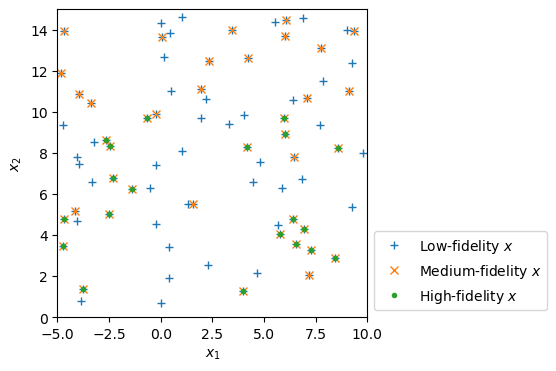

In [3]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.plot(data_low_x[:,0],data_low_x[:,1],"+",label=r"Low-fidelity $x$")
ax.plot(data_med_x[:,0],data_med_x[:,1],"x",label=r"Medium-fidelity $x$")
ax.plot(data_high_x[:,0],data_high_x[:,1],".",label=r"High-fidelity $x$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-5,10)
ax.set_ylim(0,15)
ax.legend(loc="lower left", bbox_to_anchor=(1,0))
plt.show()

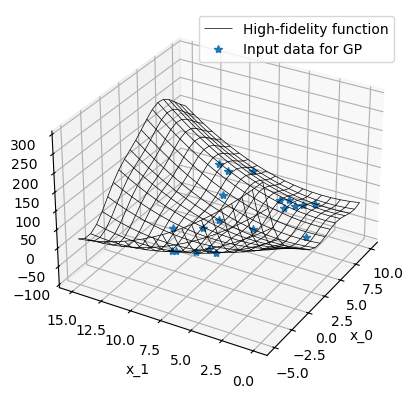

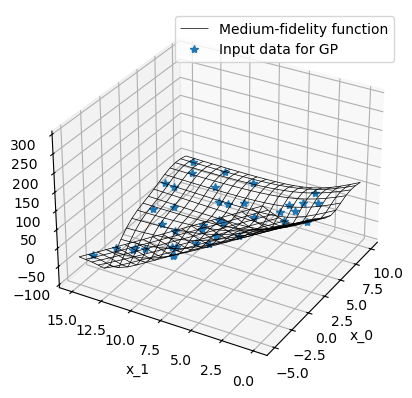

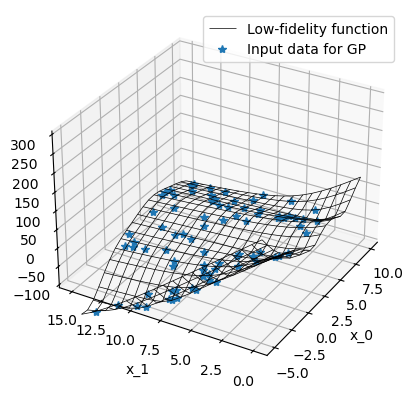

In [4]:
# 推定に用いる入力データ: Low, medium, high-fidelity dataset
data_low_y = low(data_low_x)
data_med_y = medium(data_med_x)
data_high_y = high(data_high_x)

# データセットの描画
%matplotlib inline
# %matplotlib qt
x0 = np.linspace(-5,10,20)
x1 = np.linspace(0,15,20)
x0m, x1m = np.meshgrid(x0,x1)
xm = np.stack([x0m,x1m],axis=-1)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,high(xm),lw=0.5,color="black",label="High-fidelity function")
ax.plot(data_high_x[:,0],data_high_x[:,1],data_high_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,medium(xm),lw=0.5,color="black",label="Medium-fidelity function")
ax.plot(data_med_x[:,0],data_med_x[:,1],data_med_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,low(xm),lw=0.5,color="black",label="Low-fidelity function")
ax.plot(data_low_x[:,0],data_low_x[:,1],data_low_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

### Nonlinear autoregressive meanlti-fidelity Gaussian process regression (NARGP)

In [5]:
data_list = [[data_low_x,data_low_y[:,None]],
             [data_med_x,data_med_y[:,None]],
             [data_high_x,data_high_y[:,None]]]
model_nargp = NARGP(data_list = data_list)             
model_nargp.optimize(optimize_restarts=10)
from time import time as timer
t1=timer()
mean, var = model_nargp.predict(xm.reshape(xm.size//2,2),nMonteCarlo=100)
t2=timer(); print(t2-t1, xm.size)

nfidelity= 3 , optimize_restarts= 10 , max_iters= 400


reconstraining parameters GP_regression.Gaussian_noise.variance
 /home/smae/.local/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 227.71589893718553
Optimization restart 2/10, f = 227.47331477108978
Optimization restart 3/10, f = 227.47331476236337
Optimization restart 4/10, f = 227.4733147638719
Optimization restart 5/10, f = 227.47331476244577
Optimization restart 6/10, f = 227.47331476427433
Optimization restart 7/10, f = 254.99353070629712
Optimization restart 8/10, f = 227.47331476270264
Optimization restart 9/10, f = 254.99353069484133
Optimization restart 10/10, f = 254.99353070004446


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 133.0520091859113
Optimization restart 2/10, f = 141.92644281036968


 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 3/10, f = 141.60039525105566
Optimization restart 4/10, f = 125.19573493362631
Optimization restart 5/10, f = 124.82688976797203
Optimization restart 6/10, f = 140.6159813262897


 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 7/10, f = 141.93339209452208
Optimization restart 8/10, f = 141.59896637678335
Optimization restart 9/10, f = 140.7616099333899
Optimization restart 10/10, f = 140.64664621339364


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 73.56156828753085
Optimization restart 2/10, f = 83.20922320546613
Optimization restart 3/10, f = 83.209215458187
Optimization restart 4/10, f = 74.96029708935478
Optimization restart 5/10, f = 70.2540513756442
Optimization restart 6/10, f = 83.20921822544861
Optimization restart 7/10, f = 83.20921649396419
Optimization restart 8/10, f = 83.2092167362038
Optimization restart 9/10, f = 82.75688029909679
Optimization restart 10/10, f = 83.2092159879899
88.53948140144348 800


### Single GP using only high-fidelity data (for comparison)

In [6]:
from mfmodeling import SingleGP
data = [data_high_x,data_high_y[:,None]]
model_singlegp = SingleGP(data = data)
model_singlegp.optimize()
mean_singlegp, var_singlegp = model_singlegp.predict(xm.reshape(xm.size//2,2))

optimize_restarts= 30 , max_iters= 400


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/30, f = 113.68192562315828
Optimization restart 2/30, f = 74.86310842004772
Optimization restart 3/30, f = 102.31143623383517
Optimization restart 4/30, f = 102.311676011504
Optimization restart 5/30, f = 102.31147152424732
Optimization restart 6/30, f = 74.86310842026376
Optimization restart 7/30, f = 74.86310841980011
Optimization restart 8/30, f = 74.86310846116024
Optimization restart 9/30, f = 74.86310841933971
Optimization restart 10/30, f = 74.86310841967108
Optimization restart 11/30, f = 102.31088523197658
Optimization restart 12/30, f = 74.86310841906163
Optimization restart 13/30, f = 74.86310842043979
Optimization restart 14/30, f = 74.86310842005105
Optimization restart 15/30, f = 74.86310841964692
Optimization restart 16/30, f = 74.86310841932345
Optimization restart 17/30, f = 102.30510716250669
Optimization restart 18/30, f = 74.86310841910267
Optimization restart 19/30, f = 74.86310841964874
Optimization restart 20/30, f = 74.86175544274417
Optim

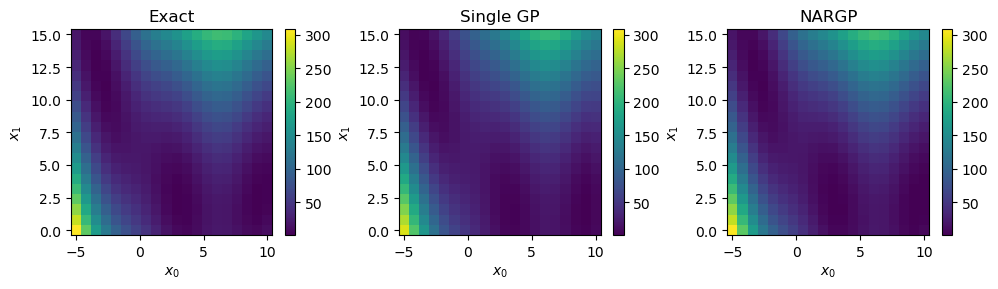

In [7]:
vmax = high(xm).max()
vmin = high(xm).min()
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
quad = ax.pcolormesh(x0m,x1m,high(xm),vmax=vmax,vmin=vmin)
ax.set_title("Exact")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(132)
quad = ax.pcolormesh(x0m,x1m,mean_singlegp.reshape(x0m.shape),vmax=vmax,vmin=vmin)
ax.set_title("Single GP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(133)
quad = ax.pcolormesh(x0m,x1m,mean.reshape(x0m.shape),vmax=vmax,vmin=vmin)
ax.set_title("NARGP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

10.235996144570684 20.69666399395689 1.115855440190379 5.525266364942908 20.69666399395689


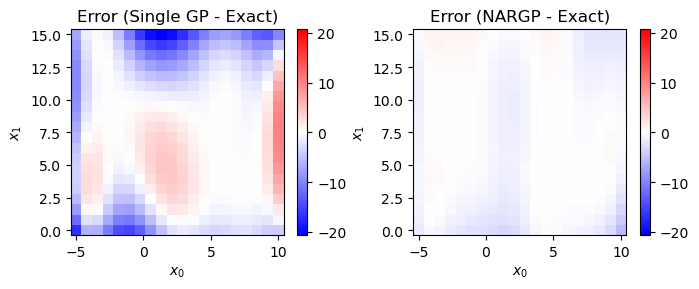

In [8]:
error_singlegp = mean_singlegp.reshape(x0m.shape)-high(xm)
error_nargp = mean.reshape(x0m.shape)-high(xm)
emax = max([error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min()])
print(error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min(),emax)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
quad = ax.pcolormesh(x0m,x1m,error_singlegp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (Single GP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(122)
quad = ax.pcolormesh(x0m,x1m,error_nargp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (NARGP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

In [ ]:
nsample = 1000
w0 = -5 + 15*np.random.rand(nsample)
w1 = 15 * np.random.rand(nsample)
xsample = np.stack([w0,w1],axis=-1)

t1=timer()
mean0, var0 = model_nargp.predict(xsample,ifidelity=0,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean1, var1 = model_nargp.predict(xsample,ifidelity=1,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean2, var2 = model_nargp.predict(xsample,ifidelity=2,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()

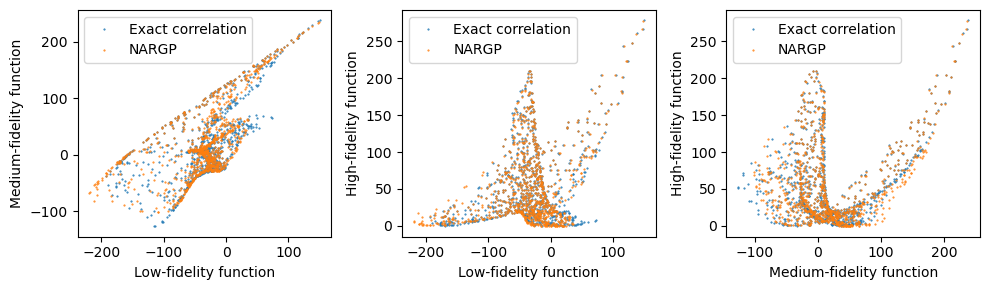

In [11]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
ax.plot(low(xsample),medium(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean0,mean1,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("Medium-fidelity function")
ax.legend()
ax = fig.add_subplot(132)
ax.plot(low(xsample),high(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean0,mean2,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("High-fidelity function")
ax.legend()
ax = fig.add_subplot(133)
ax.plot(medium(xsample),high(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean1,mean2,".",markersize=1,label="NARGP")
ax.set_xlabel("Medium-fidelity function")
ax.set_ylabel("High-fidelity function")
fig.tight_layout()
ax.legend()
plt.show()

(1000, 1) (1000, 1)


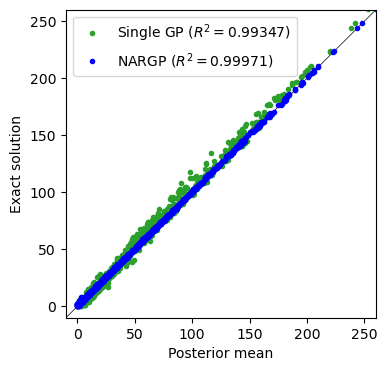

In [12]:
mean_singlegp, var_singlegp = model_singlegp.predict(xsample)
exact_high = high(xsample)[:,None]
print(exact_high.shape,mean_singlegp.shape)
R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
R2_nargp = float(1.0 - sum((exact_high-mean2)**2)/sum((exact_high-exact_high.mean())**2))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
vmin = -10
vmax = 260
ax.plot(np.linspace(vmin,vmax,2),np.linspace(vmin,vmax,2),c="k",lw=0.5)
ax.plot(mean_singlegp,exact_high,".",c="tab:green",label="Single GP ($R^2=${:.5f})".format(R2_singlegp))
ax.plot(mean2,exact_high,".",c="b",label="NARGP ($R^2=${:.5f})".format(R2_nargp))
ax.set_xlabel("Posterior mean")
ax.set_ylabel("Exact solution")
ax.set_xlim(vmin,vmax)
ax.set_ylim(vmin,vmax)
ax.legend()
plt.show()

